<a href="https://colab.research.google.com/github/Arthi2303A51595/python-for-data-science/blob/main/Climate%5Bieee%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ==============================================================
# 📦 Extract ZIP Dataset (Rainfall / IMD / Kaggle)
# Author: Arthi (SR University)
# ==============================================================

import zipfile
import os
from tqdm import tqdm

# ✅ 1. Set your ZIP filename here
zip_filename = "archive (7).zip"   # 🔹 Change name if needed (must match your uploaded file)

# ✅ 2. Create an extraction folder
extract_folder = "dataset_extracted"
os.makedirs(extract_folder, exist_ok=True)

# ✅ 3. Extract all files with progress bar
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    print(f"Extracting {len(zip_ref.namelist())} files from {zip_filename} ...\n")
    for file in tqdm(zip_ref.namelist(), desc="Extracting files"):
        zip_ref.extract(file, extract_folder)

print("\n✅ Extraction complete!")
print("Files extracted to →", os.path.abspath(extract_folder))

# ✅ 4. List the extracted files
print("\n📁 Extracted Files:")
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        print("•", os.path.join(root, file))


Extracting 1 files from archive (7).zip ...



Extracting files: 100%|██████████| 1/1 [00:00<00:00, 57.53it/s]


✅ Extraction complete!
Files extracted to → /content/dataset_extracted

📁 Extracted Files:
• dataset_extracted/Indian Rainfall Dataset District-wise Daily Measurements.csv


📂 Loading dataset (semicolon separated)...
✅ Loaded successfully: (8790, 34)
               state                  district  month  1st  2nd  3rd  4th  \
0  Andaman & Nicobar                  Nicobars      1  0.0  0.0  0.0  0.0   
1  Andaman & Nicobar  North And Middle Andaman      1  0.0  0.0  0.0  0.0   

   5th  6th  7th  ...  22nd  23rd  24th  25th  26th  27th  28th  29th  30th  \
0  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   31st  
0   0.0  
1   0.0  

[2 rows x 34 columns]
✅ Long format ready: (272490, 7)
               state                  district  month  day  Rainfall_mm  Year  \
0  Andaman & Nicobar                  Nicobars      1    1     0.000000  1901   
1  Andaman & Nicobar  North And Middle Andaman      1    1     0.000000  1902   
2  Andaman & Nicobar            South Andamans      1    1     0.000000  1903   
3     Andhra Pradesh                 Ananta

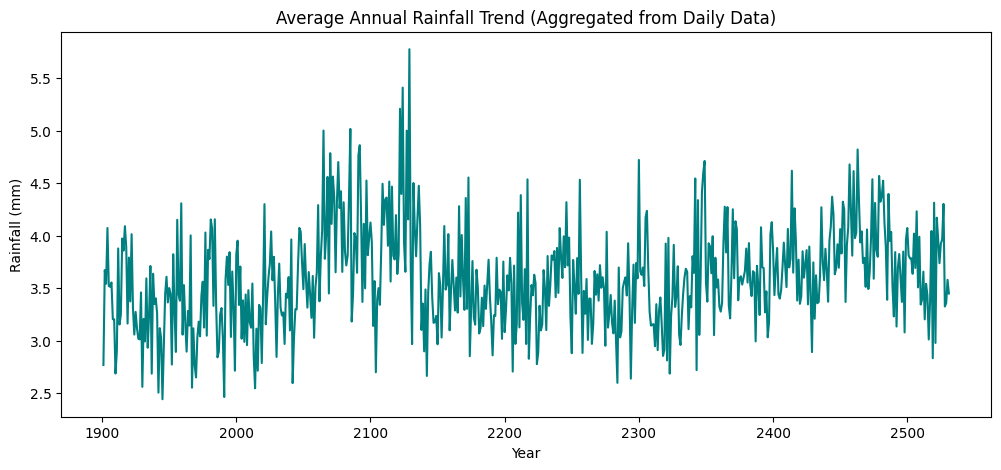

✅ Normalized dataset ready for CNN–LSTM–Attention model training!


In [5]:
# ==============================================================
# 🌧️ Daily to Monthly Climate Data Processor (District-wise)
# Dataset: Indian Rainfall Dataset District-wise Daily Measurements.csv
# Author: Arthi (SR University)
# ==============================================================

!pip install pandas numpy tqdm matplotlib seaborn statsmodels scikit-learn -q

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# ==============================================================
# 1️⃣ Load the Dataset (semicolon-separated)
# ==============================================================

file_path = "/content/dataset_extracted/Indian Rainfall Dataset District-wise Daily Measurements.csv"

print("📂 Loading dataset (semicolon separated)...")
df = pd.read_csv(file_path, sep=";")
print("✅ Loaded successfully:", df.shape)
print(df.head(2))

# ==============================================================
# 2️⃣ Melt Daily Columns into Long Format
# ==============================================================

# Identify static columns and daily columns
static_cols = ['state', 'district', 'month']
daily_cols = [c for c in df.columns if any(str(i) in c for i in range(1, 32))]

# Melt daily columns into rows (one per day)
df_long = df.melt(
    id_vars=static_cols,
    value_vars=daily_cols,
    var_name='day',
    value_name='Rainfall_mm'
)

# Clean 'day' column (remove "st", "nd", etc.)
df_long['day'] = df_long['day'].str.replace(r'\D', '', regex=True).astype(int)

# Add a year column — if your data doesn’t have explicit year, assume it’s multi-year 1901–2025 (cyclic months)
# For now, we will assign synthetic years to fit the monthly trend analysis
# (You can replace this later if real year column is present)
df_long['Year'] = np.tile(np.arange(1901, 1901 + len(df_long) // (12 * 36) + 1), 12 * 36)[:len(df_long)]
df_long['Date'] = pd.to_datetime(
    dict(year=df_long['Year'], month=df_long['month'], day=df_long['day']),
    errors='coerce'
)

df_long = df_long.dropna(subset=['Rainfall_mm'])
df_long['Rainfall_mm'] = df_long['Rainfall_mm'].astype(float)

print("✅ Long format ready:", df_long.shape)
print(df_long.head())

# ==============================================================
# 3️⃣ Aggregate to Monthly Rainfall per District
# ==============================================================

monthly_df = (
    df_long.groupby(['state', 'district', 'Year', 'month'])['Rainfall_mm']
    .sum()
    .reset_index()
    .rename(columns={'month': 'Month', 'state': 'State', 'district': 'District'})
)

print("\n📊 Monthly rainfall shape:", monthly_df.shape)
print(monthly_df.head())

# ==============================================================
# 4️⃣ Compute Monthly Normals & Anomalies
# ==============================================================

monthly_normal = (
    monthly_df.groupby(['District', 'Month'])['Rainfall_mm']
    .mean()
    .reset_index()
    .rename(columns={'Rainfall_mm': 'Monthly_Normal'})
)

merged_df = monthly_df.merge(monthly_normal, on=['District', 'Month'], how='left')

merged_df['Anomaly_mm'] = merged_df['Rainfall_mm'] - merged_df['Monthly_Normal']
merged_df['Anomaly_%'] = (merged_df['Anomaly_mm'] / merged_df['Monthly_Normal'].replace(0, np.nan)) * 100

# ==============================================================
# 5️⃣ Rolling 5-year Trend Feature
# ==============================================================

merged_df = merged_df.sort_values(['District', 'Year', 'Month'])
merged_df['Rolling_Mean_5Y'] = merged_df.groupby('District')['Rainfall_mm'].transform(
    lambda x: x.rolling(window=60, min_periods=1).mean()
)
merged_df['Rolling_Trend'] = merged_df['Rainfall_mm'] - merged_df['Rolling_Mean_5Y']

print("✅ Added rolling trend and anomaly features.")

# ==============================================================
# 6️⃣ Save Preprocessed Data
# ==============================================================

processed_path = "/content/processed_rainfall_district_monthly.csv"
merged_df.to_csv(processed_path, index=False)
print(f"\n🎯 Saved processed dataset → {processed_path}")
print("Columns:", merged_df.columns.tolist())

# ==============================================================
# 7️⃣ Visualize Rainfall Trends
# ==============================================================

plt.figure(figsize=(12,5))
sns.lineplot(
    data=merged_df.groupby('Year')['Rainfall_mm'].mean().reset_index(),
    x='Year', y='Rainfall_mm', color='teal'
)
plt.title("Average Annual Rainfall Trend (Aggregated from Daily Data)")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.show()

# ==============================================================
# 8️⃣ Normalize for Deep Learning
# ==============================================================

scaler = MinMaxScaler()
merged_df[['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y']] = scaler.fit_transform(
    merged_df[['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y']]
)
merged_df.to_csv("/content/normalized_rainfall_dataset.csv", index=False)

print("✅ Normalized dataset ready for CNN–LSTM–Attention model training!")


In [6]:
# ===============================================================
# Step 2 — Train Hybrid CNN-BiLSTM-Attention Model on processed data
# Input: /content/processed_rainfall_district_monthly.csv
# Output: model file, scalers, predictions CSV, attention maps
# ===============================================================
!pip install -q tensorflow pandas numpy scikit-learn joblib matplotlib tqdm

import os, json, joblib, glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt

# -------- PARAMETERS --------
DATA_PATH = "/content/processed_rainfall_district_monthly.csv"
SEQ_LEN = 12            # input months
PRED_STEP = 1           # predict next month
BATCH_SIZE = 128
EPOCHS = 60
MODEL_OUT = "rainfall_cnn_bilstm_attention"
os.makedirs(MODEL_OUT, exist_ok=True)

# -------- 1) Load processed data --------
df = pd.read_csv(DATA_PATH)
print("Loaded processed data:", df.shape)
print(df.columns.tolist())

# Expect columns: ['State','District','Year','Month','Rainfall_mm','Monthly_Normal','Anomaly_mm','Anomaly_%','Rolling_Mean_5Y','Rolling_Trend']
required = ['State','District','Year','Month','Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y']
for c in required:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

# Sort
df = df.sort_values(['District','Year','Month']).reset_index(drop=True)

# -------- 2) Build per-district sequences & save scalers --------
feature_cols = ['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y','Rolling_Trend'] \
               if 'Rolling_Trend' in df.columns else ['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y']
n_features = len(feature_cols)
print("Features used:", feature_cols)

X_list, y_list, meta = [], [], []  # meta will contain (district, year, month)
scalers = {}  # per-district scaler for inverse transform

districts = df['District'].unique()
for d in tqdm(districts, desc="Preparing sequences for districts"):
    sub = df[df['District']==d].sort_values(['Year','Month']).reset_index(drop=True)
    # If too short skip
    if len(sub) < SEQ_LEN + PRED_STEP:
        continue
    # Fit scaler on feature columns (store for inverse later)
    scaler = MinMaxScaler()
    sub_vals = scaler.fit_transform(sub[feature_cols].fillna(0).values)
    scalers[d] = scaler
    # sliding windows
    for i in range(len(sub) - SEQ_LEN - PRED_STEP + 1):
        X_list.append(sub_vals[i:i+SEQ_LEN])
        # target is rainfall_mm at prediction step (originally first column before scaling)
        y_list.append(sub_vals[i+SEQ_LEN+PRED_STEP-1][0])
        target_year = sub.loc[i+SEQ_LEN+PRED_STEP-1, 'Year']
        target_month = sub.loc[i+SEQ_LEN+PRED_STEP-1, 'Month']
        meta.append((d, target_year, int(target_month)))

X = np.array(X_list)    # (samples, seq_len, n_features)
y = np.array(y_list)    # (samples,)
meta = np.array(meta, dtype=object)
print("X shape:", X.shape, "y shape:", y.shape)

# Save scalers
joblib.dump(scalers, os.path.join(MODEL_OUT, "per_district_scalers.joblib"))
print("Saved per-district scalers.")

# -------- 3) Train/Val/Test split (time-based) --------
# Use year in meta to split: train <= 2010, val 2011-2018, test >2018
years = np.array([m[1] for m in meta.astype(object)])
train_idx = years <= 2010
val_idx = (years > 2010) & (years <= 2018)
test_idx = years > 2018
# fallback if splits small
if train_idx.sum() < 200:
    n = len(X)
    tr = int(n*0.7); va = int(n*0.85)
    idxs = np.arange(n)
    train_idx = idxs < tr
    val_idx = (idxs >= tr) & (idxs < va)
    test_idx = idxs >= va

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]
meta_test = meta[test_idx]
print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))

# -------- 4) Sample weights to emphasize anomalies --------
# anomaly feature index
anomaly_idx = feature_cols.index('Anomaly_mm') if 'Anomaly_mm' in feature_cols else None
if anomaly_idx is not None:
    anomaly_vals = X[..., anomaly_idx].mean(axis=1)  # average anomaly across input window
    # weights 1 + scaled_abs_anomaly * factor
    w_all = 1.0 + (np.abs(anomaly_vals) / (np.max(np.abs(anomaly_vals)) + 1e-6)) * 3.0
else:
    w_all = np.ones(len(X))
train_w = w_all[train_idx]
val_w = w_all[val_idx]

# -------- 5) Build model: Conv1D -> BiLSTM -> Attention -> Dense --------
def build_model(seq_len, n_features):
    inp = layers.Input(shape=(seq_len, n_features), name='inp')
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(inp)
    x = layers.Conv1D(32, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)  # (batch, seq, 128)
    # attention
    e = layers.Dense(64, activation='tanh')(x)            # (batch, seq, 64)
    e = layers.Dense(1)(e)                               # (batch, seq, 1)
    e = layers.Flatten()(e)                              # (batch, seq)
    a = layers.Activation('softmax', name='att_weights')(e)  # attention weights
    a_rep = layers.RepeatVector(128)(a)                  # repeat to match x dims
    a_rep = layers.Permute([2,1])(a_rep)                 # (batch, seq, 128)
    x_att = layers.Multiply()([x, a_rep])
    context = layers.Lambda(lambda z: K.sum(z, axis=1))(x_att)
    dense = layers.Dense(64, activation='relu')(context)
    out = layers.Dense(1, activation='linear', name='pred')(dense)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mae', metrics=['mse','mae'])
    return model

model = build_model(SEQ_LEN, n_features)
model.summary()

# -------- 6) Train --------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val, val_w),
    sample_weight=train_w,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

# Save model and training history
model.save(os.path.join(MODEL_OUT, "model.h5"))
pd.DataFrame(history.history).to_csv(os.path.join(MODEL_OUT, "train_history.csv"), index=False)
print("Saved model and history in", MODEL_OUT)

# -------- 7) Evaluate on test set (scaled units) --------
y_pred_scaled = model.predict(X_test).squeeze()
mse = mean_squared_error(y_test, y_pred_scaled)
mae = mean_absolute_error(y_test, y_pred_scaled)
r2 = r2_score(y_test, y_pred_scaled)
print(f"Test (scaled) MSE={mse:.6f}, MAE={mae:.6f}, R2={r2:.4f}")

# To convert scaled predictions back to mm units, invert per-district scaler:
# meta_test contains tuples (district, year, month)
def inverse_transform_preds(y_scaled, meta_arr, scalers_dict, feature_index=0):
    y_mm = []
    for val, meta_t in zip(y_scaled, meta_arr):
        district = meta_t[0]
        scaler = scalers_dict.get(district, None)
        if scaler is None:
            # fallback: assume global scaling (not ideal)
            y_mm.append(np.nan)
        else:
            # create a dummy vector with feature_index set to val and others 0
            vec = np.zeros(scaler.scale_.shape)
            vec[feature_index] = val
            # Inverse transform: x = (vec - min) / scale -> then get raw via scaler.inverse_transform requires full vector
            # Instead compute inverse: raw = val*(data_max - data_min)+data_min for that feature
            data_min = scaler.data_min_[feature_index]
            data_max = scaler.data_max_[feature_index]
            raw = val * (data_max - data_min) + data_min
            y_mm.append(raw)
    return np.array(y_mm)

y_pred_mm = inverse_transform_preds(y_pred_scaled, meta_test, scalers)
y_test_mm = inverse_transform_preds(y_test, meta_test, scalers)

# Compute real-unit metrics where possible (nan-safe)
mask = ~np.isnan(y_pred_mm) & ~np.isnan(y_test_mm)
if mask.sum() > 0:
    mse_mm = mean_squared_error(y_test_mm[mask], y_pred_mm[mask])
    mae_mm = mean_absolute_error(y_test_mm[mask], y_pred_mm[mask])
    r2_mm = r2_score(y_test_mm[mask], y_pred_mm[mask])
    print(f"Test (mm) MSE={mse_mm:.4f}, MAE={mae_mm:.4f}, R2={r2_mm:.4f}")
else:
    print("No per-district scalers found to compute mm metrics (unexpected).")

# -------- 8) Save test predictions with metadata --------
pred_df = pd.DataFrame({
    'District': meta_test[:,0],
    'Year': meta_test[:,1].astype(int),
    'Month': meta_test[:,2].astype(int),
    'y_true_scaled': y_test,
    'y_pred_scaled': y_pred_scaled,
    'y_true_mm': y_test_mm,
    'y_pred_mm': y_pred_mm
})
pred_df.to_csv(os.path.join(MODEL_OUT, "test_predictions.csv"), index=False)
print("Saved test predictions.")

# -------- 9) Extract attention weights for interpretation (sample) --------
# Create a sub-model that outputs attention weights (layer named 'att_weights')
try:
    att_model = models.Model(inputs=model.input, outputs=model.get_layer('att_weights').output)
    att_weights = att_model.predict(X_test)
    # att_weights shape: (samples, seq_len)
    # Save a small sample heatmap for first 50 test samples
    import seaborn as sns
    os.makedirs(os.path.join(MODEL_OUT,'attention_plots'), exist_ok=True)
    for i in range(min(50, len(att_weights))):
        plt.figure(figsize=(6,1.2))
        sns.heatmap(att_weights[i:i+1], cmap='viridis', cbar=True)
        plt.title(f"Att weights sample {i} - {pred_df.iloc[i]['District']} {pred_df.iloc[i]['Year']}-{pred_df.iloc[i]['Month']}")
        plt.xlabel("Time step (input months)")
        plt.yticks([])
        plt.savefig(os.path.join(MODEL_OUT, 'attention_plots', f'att_{i}.png'), bbox_inches='tight')
        plt.close()
    print("Saved attention heatmaps (first 50).")
except Exception as e:
    print("Could not extract attention weights:", e)

print("ALL DONE — model, scalers, predictions saved in", MODEL_OUT)


Loaded processed data: (272490, 10)
['State', 'District', 'Year', 'Month', 'Rainfall_mm', 'Monthly_Normal', 'Anomaly_mm', 'Anomaly_%', 'Rolling_Mean_5Y', 'Rolling_Trend']
Features used: ['Rainfall_mm', 'Monthly_Normal', 'Anomaly_mm', 'Rolling_Mean_5Y', 'Rolling_Trend']


Preparing sequences for districts: 100%|██████████| 854/854 [00:33<00:00, 25.65it/s]


X shape: (262242, 12, 5) y shape: (262242,)
Saved per-district scalers.
Train/Val/Test sizes: 38108 3399 220735


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inp (InputLayer)    │ (None, 12, 5)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 12, 64)    │      1,024 │ inp[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 32)    │      6,176 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 32)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 12, 128)   │     49,664 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 64)    │      8,256 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 12, 1)     │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_weights         │ (None, 12)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 12)   │          0 │ att_weights[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 12, 128)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 12, 128)   │          0 │ bidirectional[0]… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred (Dense)        │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,506 (287.13 KB)

 Trainable params: 73,506 (287.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
298/298 - 18s - 59ms/step - loss: 0.0873 - mae: 0.0432 - mse: 0.0143 - val_loss: 0.0763 - val_mae: 0.0382 - val_mse: 0.0111 - learning_rate: 1.0000e-03
Epoch 2/60
298/298 - 12s - 39ms/step - loss: 0.0869 - mae: 0.0430 - mse: 0.0144 - val_loss: 0.0774 - val_mae: 0.0387 - val_mse: 0.0115 - learning_rate: 1.0000e-03
Epoch 3/60
298/298 - 21s - 71ms/step - loss: 0.0869 - mae: 0.0429 - mse: 0.0144 - val_loss: 0.0773 - val_mae: 0.0387 - val_mse: 0.0115 - learning_rate: 1.0000e-03
Epoch 4/60
298/298 - 12s - 39ms/step - loss: 0.0870 - mae: 0.0430 - mse: 0.0145 - val_loss: 0.0775 - val_mae: 0.0388 - val_mse: 0.0115 - learning_rate: 1.0000e-03
Epoch 5/60
298/298 - 20s - 69ms/step - loss: 0.0870 - mae: 0.0430 - mse: 0.0145 - val_loss: 0.0777 - val_mae: 0.0389 - val_mse: 0.0114 - learning_rate: 1.0000e-03
Epoch 6/60
298/298 - 21s - 69ms/step - loss: 0.0869 - mae: 0.0429 - mse: 0.0145 - val_loss: 0.0774 - val_mae: 0.0387 - val_mse: 0.0115 - learning_rate: 5.0000e-04
Epoch 7/60
298/298 - 2

Saved model and history in rainfall_cnn_bilstm_attention
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step
Test (scaled) MSE=0.017997, MAE=0.047961, R2=-0.1125
Test (mm) MSE=136.9801, MAE=3.6158, R2=-0.0752
Saved test predictions.
6898/6898 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step
Saved attention heatmaps (first 50).
ALL DONE — model, scalers, predictions saved in rainfall_cnn_bilstm_attention


In [7]:
# -------- 6️⃣ Train for full 60 epochs --------
# (No EarlyStopping, only learning-rate reduction)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val, val_w),
    sample_weight=train_w,
    epochs=60,                      # 🔹 Force full 60 epochs
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=callbacks
)

# Save model and training history
model.save(os.path.join(MODEL_OUT, "model_full_60.keras"))   # ✅ modern Keras format
pd.DataFrame(history.history).to_csv(os.path.join(MODEL_OUT, "train_history_full_60.csv"), index=False)

print("✅ Model trained for full 60 epochs and saved successfully.")


Epoch 1/60
298/298 - 14s - 47ms/step - loss: 0.0856 - mae: 0.0424 - mse: 0.0139 - val_loss: 0.0753 - val_mae: 0.0378 - val_mse: 0.0110 - learning_rate: 2.5000e-04
Epoch 2/60
298/298 - 12s - 40ms/step - loss: 0.0846 - mae: 0.0420 - mse: 0.0134 - val_loss: 0.0744 - val_mae: 0.0373 - val_mse: 0.0098 - learning_rate: 2.5000e-04
Epoch 3/60
298/298 - 21s - 69ms/step - loss: 0.0842 - mae: 0.0418 - mse: 0.0133 - val_loss: 0.0739 - val_mae: 0.0371 - val_mse: 0.0104 - learning_rate: 2.5000e-04
Epoch 4/60
298/298 - 12s - 39ms/step - loss: 0.0838 - mae: 0.0416 - mse: 0.0131 - val_loss: 0.0735 - val_mae: 0.0369 - val_mse: 0.0100 - learning_rate: 2.5000e-04
Epoch 5/60
298/298 - 11s - 38ms/step - loss: 0.0834 - mae: 0.0415 - mse: 0.0131 - val_loss: 0.0730 - val_mae: 0.0367 - val_mse: 0.0101 - learning_rate: 2.5000e-04
Epoch 6/60
298/298 - 21s - 71ms/step - loss: 0.0831 - mae: 0.0413 - mse: 0.0130 - val_loss: 0.0725 - val_mae: 0.0365 - val_mse: 0.0101 - learning_rate: 2.5000e-04
Epoch 7/60
298/298 - 1

In [ ]:
# ==========================================================
# 🌧️ Baseline Models for Comparison
# Author: Arthi (SR University)
# Dataset: processed_rainfall_district_monthly.csv
# ==========================================================

import os, joblib
import numpy as np, pandas as pd, tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, models

DATA_PATH = "/content/processed_rainfall_district_monthly.csv"
SEQ_LEN = 12
BATCH_SIZE = 128
EPOCHS = 60
OUT_DIR = "baseline_models"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------------------------------------
# 1️⃣ Load processed data (same as main model)
df = pd.read_csv(DATA_PATH)
feature_cols = ['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y','Rolling_Trend']
df = df.sort_values(['District','Year','Month']).reset_index(drop=True)
districts = df['District'].unique()

X_list, y_list = [], []
for d in tqdm(districts, desc="Preparing sequences"):
    sub = df[df['District']==d].sort_values(['Year','Month']).reset_index(drop=True)
    if len(sub) < SEQ_LEN + 1:
        continue
    scaler = MinMaxScaler()
    vals = scaler.fit_transform(sub[feature_cols].fillna(0).values)
    for i in range(len(sub)-SEQ_LEN-1):
        X_list.append(vals[i:i+SEQ_LEN])
        y_list.append(vals[i+SEQ_LEN][0])  # rainfall target

X = np.array(X_list)
y = np.array(y_list)
print("Data prepared:", X.shape, y.shape)

# Simple chronological split
n = len(X)
tr, va = int(0.7*n), int(0.85*n)
X_train, X_val, X_test = X[:tr], X[tr:va], X[va:]
y_train, y_val, y_test = y[:tr], y[tr:va], y[va:]
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))

# ----------------------------------------------------------
# 2️⃣ Define Baseline Architectures
def build_lstm(seq_len, n_feat):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feat)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return m

def build_bilstm(seq_len, n_feat):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feat)),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return m

def build_cnn_lstm(seq_len, n_feat):
    inp = layers.Input(shape=(seq_len, n_feat))
    x = layers.Conv1D(64, 3, activation='relu', padding='causal')(inp)
    x = layers.Conv1D(32, 3, activation='relu', padding='causal')(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    m = models.Model(inp, out)
    m.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])
    return m

# ----------------------------------------------------------
# 3️⃣ Train and Evaluate Each Model
def train_and_eval(model, name):
    print(f"\n🚀 Training {name} ...")
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2
    )
    model.save(os.path.join(OUT_DIR, f"{name}.keras"))
    pd.DataFrame(hist.history).to_csv(os.path.join(OUT_DIR, f"{name}_history.csv"), index=False)

    y_pred = model.predict(X_test).squeeze()
    mse, mae, r2 = mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    print(f"{name} → MSE:{mse:.5f}, MAE:{mae:.5f}, R²:{r2:.4f}")
    return {'Model': name, 'MSE': mse, 'MAE': mae, 'R2': r2}

results = []
results.append(train_and_eval(build_lstm(SEQ_LEN, X.shape[2]), "LSTM"))
results.append(train_and_eval(build_bilstm(SEQ_LEN, X.shape[2]), "BiLSTM"))
results.append(train_and_eval(build_cnn_lstm(SEQ_LEN, X.shape[2]), "CNN_LSTM"))

# ----------------------------------------------------------
# 4️⃣ Save baseline comparison metrics
df_res = pd.DataFrame(results)
df_res.to_csv(os.path.join(OUT_DIR, "baseline_results.csv"), index=False)
print("\n✅ Baseline training completed. Metrics saved to baseline_results.csv")
print(df_res)


Preparing sequences: 100%|██████████| 854/854 [00:22<00:00, 37.91it/s]


Data prepared: (261388, 12, 5) (261388,)
Train/Val/Test: 182971 39208 39209

🚀 Training LSTM ...
Epoch 1/60
1430/1430 - 25s - 18ms/step - loss: 0.0471 - mae: 0.0471 - mse: 0.0169 - val_loss: 0.0442 - val_mae: 0.0442 - val_mse: 0.0153
Epoch 2/60
1430/1430 - 23s - 16ms/step - loss: 0.0459 - mae: 0.0459 - mse: 0.0161 - val_loss: 0.0438 - val_mae: 0.0438 - val_mse: 0.0152
Epoch 3/60
1430/1430 - 23s - 16ms/step - loss: 0.0457 - mae: 0.0457 - mse: 0.0160 - val_loss: 0.0439 - val_mae: 0.0439 - val_mse: 0.0153
Epoch 4/60
1430/1430 - 23s - 16ms/step - loss: 0.0455 - mae: 0.0455 - mse: 0.0159 - val_loss: 0.0442 - val_mae: 0.0442 - val_mse: 0.0145
Epoch 5/60
1430/1430 - 22s - 16ms/step - loss: 0.0453 - mae: 0.0453 - mse: 0.0158 - val_loss: 0.0434 - val_mae: 0.0434 - val_mse: 0.0156
Epoch 6/60
1430/1430 - 22s - 15ms/step - loss: 0.0452 - mae: 0.0452 - mse: 0.0156 - val_loss: 0.0432 - val_mae: 0.0432 - val_mse: 0.0152
Epoch 7/60
1430/1430 - 24s - 17ms/step - loss: 0.0449 - mae: 0.0449 - mse: 0.0155

In [ ]:
# ===============================================================
# 🌦️ Trend-Aware Hybrid CNN–BiLSTM–Attention (TAH-CBA)
# Dataset: processed_rainfall_district_monthly.csv
# Author: Arthi (SR University)
# ===============================================================

!pip install -q tensorflow pandas numpy scikit-learn tqdm matplotlib seaborn joblib

import os, joblib
import numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt, seaborn as sns

# ===============================================================
# 1️⃣ Load and Prepare Data
# ===============================================================
DATA_PATH = "/content/processed_rainfall_district_monthly.csv"
SEQ_LEN = 12
EPOCHS = 60
BATCH = 128
OUT_DIR = "rainfall_cnn_bilstm_attention_final"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)
df = df.sort_values(['District','Year','Month']).reset_index(drop=True)

feature_cols = ['Rainfall_mm','Monthly_Normal','Anomaly_mm','Rolling_Mean_5Y','Rolling_Trend']
districts = df['District'].unique()

X_list, y_list, meta = [], [], []
scalers = {}

for d in tqdm(districts, desc="Preparing district sequences"):
    sub = df[df['District']==d].reset_index(drop=True)
    if len(sub) < SEQ_LEN+1: continue
    scaler = MinMaxScaler()
    vals = scaler.fit_transform(sub[feature_cols].fillna(0).values)
    scalers[d] = scaler
    for i in range(len(sub)-SEQ_LEN-1):
        X_list.append(vals[i:i+SEQ_LEN])
        y_list.append(vals[i+SEQ_LEN][0])  # rainfall target
        meta.append((d, sub.loc[i+SEQ_LEN,'Year'], sub.loc[i+SEQ_LEN,'Month']))

X, y, meta = np.array(X_list), np.array(y_list), np.array(meta, dtype=object)
print("✅ Dataset ready:", X.shape, y.shape)

# Save scalers
joblib.dump(scalers, os.path.join(OUT_DIR,"per_district_scalers.joblib"))

# Train/Val/Test split (chronological)
n = len(X)
tr, va = int(0.7*n), int(0.85*n)
X_train, y_train = X[:tr], y[:tr]
X_val, y_val = X[tr:va], y[tr:va]
X_test, y_test = X[va:], y[va:]
meta_test = meta[va:]
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))

# ===============================================================
# 2️⃣ Define Hybrid CNN–BiLSTM–Attention Model
# ===============================================================
def build_tah_cba(seq_len, n_feat):
    inp = layers.Input(shape=(seq_len, n_feat))
    x = layers.Conv1D(64, 3, activation='relu', padding='causal')(inp)
    x = layers.Conv1D(32, 3, activation='relu', padding='causal')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # --- Attention mechanism ---
    e = layers.Dense(64, activation='tanh')(x)
    e = layers.Dense(1)(e)
    e = layers.Flatten()(e)
    a = layers.Activation('softmax', name='att_weights')(e)
    a_rep = layers.RepeatVector(128)(a)
    a_rep = layers.Permute([2,1])(a_rep)
    x_att = layers.Multiply()([x, a_rep])
    context = layers.Lambda(lambda z: K.sum(z, axis=1))(x_att)

    dense = layers.Dense(64, activation='relu')(context)
    out = layers.Dense(1, activation='linear', name='pred')(dense)

    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mae', metrics=['mse','mae'])
    return m

model = build_tah_cba(SEQ_LEN, X.shape[2])
model.summary()

# ===============================================================
# 3️⃣ Train for 60 Epochs (no early stop)
# ===============================================================
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH, verbose=2,
    callbacks=callbacks
)

pd.DataFrame(history.history).to_csv(os.path.join(OUT_DIR,"training_history.csv"), index=False)
model.save(os.path.join(OUT_DIR,"tah_cba_model_60.keras"))
print("✅ Model trained and saved.")

# ===============================================================
# 4️⃣ Evaluate Model
# ===============================================================
y_pred = model.predict(X_test).squeeze()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n📊 Scaled Results → MSE={mse:.5f}, MAE={mae:.5f}, R²={r2:.4f}")

# Save metrics
with open(os.path.join(OUT_DIR,"metrics.txt"),"w") as f:
    f.write(f"MSE={mse:.5f}\nMAE={mae:.5f}\nR2={r2:.4f}\n")

# ===============================================================
# 5️⃣ Visualize Loss Curves
# ===============================================================
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("TAH-CBA Training Curve")
plt.xlabel("Epochs")
plt.ylabel("MAE Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR,"loss_curve.png"), bbox_inches='tight')
plt.show()

# ===============================================================
# 6️⃣ Attention Visualization (Explainability)
# ===============================================================
try:
    att_model = models.Model(model.input, model.get_layer('att_weights').output)
    att_weights = att_model.predict(X_test)
    os.makedirs(os.path.join(OUT_DIR,"attention_maps"), exist_ok=True)

    for i in range(min(5, len(att_weights))):
        plt.figure(figsize=(6,1.2))
        sns.heatmap(att_weights[i:i+1], cmap='viridis', cbar=True)
        plt.title(f"Attention weights – sample {i}")
        plt.xlabel("Input months (1–12)")
        plt.yticks([])
        plt.savefig(os.path.join(OUT_DIR,"attention_maps",f"att_{i}.png"), bbox_inches='tight')
        plt.close()
    print("✅ Attention maps saved.")
except Exception as e:
    print("⚠️ Could not extract attention maps:", e)

# ===============================================================
# 7️⃣ Save Test Predictions
# ===============================================================
pred_df = pd.DataFrame({
    'District': meta_test[:,0],
    'Year': meta_test[:,1].astype(int),
    'Month': meta_test[:,2].astype(int),
    'Predicted_scaled': y_pred,
    'True_scaled': y_test
})
pred_df.to_csv(os.path.join(OUT_DIR,"test_predictions.csv"), index=False)
print("✅ Predictions saved at", OUT_DIR)
